# Notebook 2 – Clustering of Super Bowl Games

## 1. Introduction

This notebook focuses on the application of **unsupervised clustering techniques** to the historical Super Bowl dataset (1967–2020). Building upon the exploratory data analysis (EDA) conducted previously, this notebook aims to group Super Bowl games with similar characteristics to uncover underlying patterns and relationships in the data.

The dataset contains information about game results, winning and losing teams, stadiums, cities, and MVPs, allowing the identification of trends related to scoring patterns, venue distribution, and team performance.

This notebook follows a structured workflow for clustering, including:

- Definition of business goals

- Data selection and preparation

- Application and evaluation of the K-Means algorithm

- Optimization of clustering parameters

- Detailed analysis of cluster characteristics

The results obtained in this notebook provide insights into patterns of Super Bowl games, supporting sports analysts, commentators, and enthusiasts in understanding historical trends and game similarities.

---

## 2. Dataset Loading and Initial Inspection

In this section, the Super Bowl dataset is loaded and an initial inspection is performed to verify its structure, dimensions, and data types.

In [1]:
import pandas as pd
import numpy as np

superbowl_df = pd.read_csv("superbowl.csv")

# Display the first rows of the dataset
superbowl_df.head()

# Check the shape of the dataset
superbowl_df.shape

# Inspect data types and missing values
superbowl_df.info()

# Summary statistics for numerical attributes
superbowl_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        54 non-null     object
 1   SB          54 non-null     object
 2   Winner      54 non-null     object
 3   Winner Pts  54 non-null     int64 
 4   Loser       54 non-null     object
 5   Loser Pts   54 non-null     int64 
 6   MVP         54 non-null     object
 7   Stadium     54 non-null     object
 8   City        54 non-null     object
 9   State       54 non-null     object
dtypes: int64(2), object(8)
memory usage: 4.3+ KB


,Winner Pts,Loser Pts
count,54.000000,54.000000
mean,30.111111,16.203704
std,9.766455,7.413348
min,13.000000,3.000000
25%,23.250000,10.000000
50%,30.500000,17.000000
75%,35.000000,21.000000
max,55.000000,33.000000


---

## 3. Business Goal

The main business goal of this notebook is to develop and evaluate **unsupervised clustering models** capable of grouping Super Bowl games with similar characteristics.

Using historical data from the Super Bowl (1967–2020), this analysis aims to:

- Identify clusters of games with similar scoring patterns, competitiveness, and venue characteristics.

- Analyze the distribution of numerical attributes (e.g., points scored by winner and loser) within each cluster.

- Examine the distribution of categorical attributes (e.g., winning team, stadium, city, MVP) across clusters.

- Provide insights into historical trends in Super Bowl games and identify patterns that may be useful for sports analysts, commentators, and enthusiasts.

---

## 4. Data Preparation

The data preparation process focuses on selecting relevant features, handling missing values, and transforming categorical and numerical attributes to a suitable format for clustering.

### 4.1 Selected Features

For the purposes of clustering, the following features were selected:

- **Numerical features:**

    - `Winner Pts` – Points scored by the winning team

    - `Loser Pts` – Points scored by the losing team

- **Categorical features (optional for encoding):**

    - `Winner` – Winning team

    - `Loser` – Losing team

    - `MVP` – Most Valuable Player

    - `Stadium` – Name of the stadium

    - `City` – City where the game was played

    - `State` – State where the stadium is located

### 4.2 Data Cleaning

In this dataset, an initial inspection revealed no missing values in either numerical or categorical attributes. Therefore, no imputation or removal of rows is required. All selected features are complete and ready for transformation.

In [2]:
# Verify missing values
superbowl_df.isnull().sum()

Date          0
SB            0
Winner        0
Winner Pts    0
Loser         0
Loser Pts     0
MVP           0
Stadium       0
City          0
State         0
dtype: int64

### 4.3 Data Transformation

Before applying K-Means clustering, all features must be numeric, and numerical features should be normalized to ensure fair distance calculations.

#### 4.3.1 Transforming Categorical Variables

Categorical features such as `Winner`, `Loser`, `MVP`, `Stadium`, `City`, and `State` are transformed into numeric labels using **Label Encoding**.

In [4]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Winner', 'Loser', 'MVP', 'Stadium', 'City', 'State']

le = LabelEncoder()
for col in categorical_cols:
    superbowl_df[col] = le.fit_transform(superbowl_df[col])

# Check first rows to confirm encoding
superbowl_df.head()

,Date,SB,Winner,Winner Pts,Loser,Loser Pts,MVP,Stadium,City,State
0,Feb 2 2020,LIV (54),7,31,21,20,33,5,10,2
1,Feb 3 2019,LIII (53),10,13,12,3,22,12,1,3
2,Feb 4 2018,LII (52),15,41,15,33,31,31,11,7
3,Feb 5 2017,LI (51),10,34,1,28,43,16,5,9
4,Feb 7 2016,50,4,24,4,10,45,8,17,1


### 4.3.2 Normalizing Numerical Features

Numerical features `Winner Pts` and `Loser Pts` are standardized using **StandardScaler**, ensuring that all features contribute equally to the clustering process.

In [5]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['Winner Pts', 'Loser Pts']

scaler = StandardScaler()
superbowl_df[numerical_cols] = scaler.fit_transform(superbowl_df[numerical_cols])

# Confirm normalization
superbowl_df[numerical_cols].describe()


,Winner Pts,Loser Pts
count,5.400000e+01,5.400000e+01
mean,6.167906e-17,2.055969e-16
std,1.009390e+00,1.009390e+00
min,-1.768480e+00,-1.797796e+00
25%,-7.091146e-01,-8.446867e-01
50%,4.019273e-02,1.084225e-01
75%,5.052800e-01,6.530562e-01
max,2.572335e+00,2.286958e+00


### 4.3.3 Final Dataset for Clustering

After encoding and normalization, all features are numeric and ready to be used in K-Means. The final feature matrix `X` is created as follows:

In [6]:
X = superbowl_df[['Winner Pts', 'Loser Pts', 'Winner', 'Loser', 'MVP', 'Stadium', 'City', 'State']]

This matrix X is now suitable for clustering analysis with K-Means.

---

# 5. Apply and Evaluate the K-Means Algorithm

This section focuses on applying the **K-Means clustering algorithm** to the prepared Super Bowl dataset and evaluating the resulting clusters. K-Means groups games with similar characteristics based on the selected features.

### 5.1 Determining the Optimal Number of Clusters

Before fitting the final model, it is important to select an appropriate number of clusters (`k`). Two common methods are used:

1. **Elbow Method** – examines the total within-cluster sum of squares (inertia) as a function of `k`.

2. **Silhouette Score** – evaluates the compactness and separation of clusters.

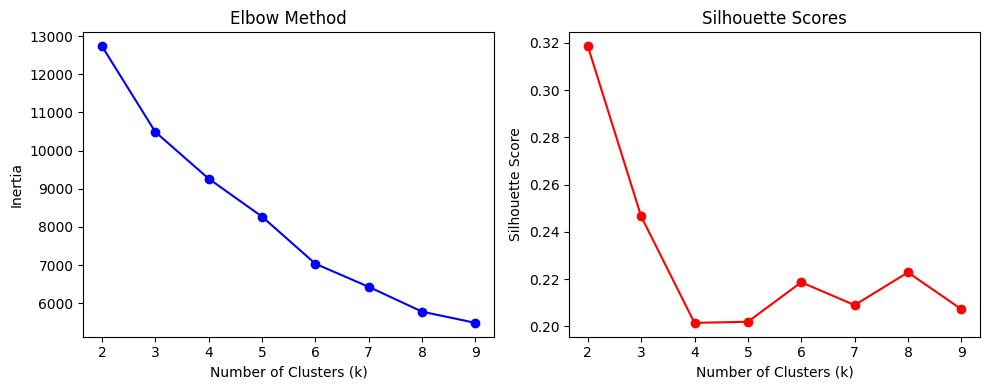

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of k to test
K = range(2, 10)

inertia = []
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()


**Interpretation:**

- The “elbow” in the inertia plot suggests a point where adding more clusters does not significantly reduce within-cluster variance.

- A high silhouette score indicates well-separated and compact clusters.

- Based on these plots, choose an optimal `k` (for example, `k=3`).

### 5.2 Fitting the Final K-Means Model

Once the optimal number of clusters is selected, fit the final K-Means model and assign cluster labels to each game.

In [8]:
# Set optimal number of clusters
optimal_k = 3

# Fit K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
superbowl_df['cluster'] = kmeans_final.fit_predict(X)

# Display first rows with cluster labels
superbowl_df.head()

,Date,SB,Winner,Winner Pts,Loser,Loser Pts,MVP,Stadium,City,State,cluster
0,Feb 2 2020,LIV (54),7,0.091869,21,0.516898,33,5,10,2,2
1,Feb 3 2019,LIII (53),10,-1.768480,12,-1.797796,22,12,1,3,0
2,Feb 4 2018,LII (52),15,1.125396,15,2.286958,31,31,11,7,2
3,Feb 5 2017,LI (51),10,0.401927,1,1.606165,43,16,5,9,2
4,Feb 7 2016,50,4,-0.631600,4,-0.844687,45,8,17,1,2


### 5.3 Evaluating the Clusters

After clustering, evaluate the results:

1. **Number of elements in each cluster**

In [9]:
superbowl_df['cluster'].value_counts()

cluster
2    22
0    17
1    15
Name: count, dtype: int64

2. **Cluster centroids (in scaled space)**

In [10]:
kmeans_final.cluster_centers_

array([[-0.23034826, -0.22796899,  9.94117647, 14.64705882, 10.11764706,
         8.41176471,  7.41176471,  3.47058824],
       [-0.19062838, -0.37267071, 11.66666667, 12.33333333, 16.86666667,
        24.8       , 12.2       ,  2.8       ],
       [ 0.30797028,  0.43025152, 10.40909091,  9.95454545, 37.54545455,
        18.04545455, 11.45454545,  3.45454545]])

3. **Silhouette Score of the final clustering**

In [11]:
sil_score = silhouette_score(X, superbowl_df['cluster'])
print("Silhouette Score:", sil_score)

Silhouette Score: 0.24652720218267188


**Interpretation:**

- The number of elements shows how games are distributed across clusters.

- Cluster centroids summarize the “average” characteristics of games in each cluster.

- The silhouette score provides an overall measure of cluster quality: closer to 1 is better, closer to 0 indicates overlapping clusters.

## 6. Optimize the Algorithm Parameters

After applying K-Means and evaluating the initial clustering, the next step is to **optimize the algorithm parameters** to improve cluster quality and stability. K-Means has several parameters that can be adjusted:

### 6.1 Parameters to Optimize

1. **n_clusters** – number of clusters

    - Already selected using the Elbow Method and Silhouette Score.

    - Can test a small range around the initial choice to see if clustering improves.

2. **init** – method for initializing centroids

    - `'k-means++'` (default) → spreads centroids to speed up convergence and improve results

    - `'random'` → random initialization

3. **n_init** – number of times the algorithm will run with different centroid seeds

    - Higher values can increase stability of clustering results.

4. **max_iter** – maximum iterations per run

    - Usually 300–1000; higher values allow better convergence.

### 6.2 Testing Different Configurations

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different parameter combinations
results = []

for n_init in [10, 20, 50]:
    for max_iter in [300, 500, 1000]:
        kmeans_test = KMeans(
            n_clusters=optimal_k,
            init='k-means++',
            n_init=n_init,
            max_iter=max_iter,
            random_state=42
        )
        labels = kmeans_test.fit_predict(X)
        sil = silhouette_score(X, labels)
        results.append((n_init, max_iter, sil))

# Convert results to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results, columns=['n_init', 'max_iter', 'Silhouette_Score'])
results_df.sort_values(by='Silhouette_Score', ascending=False)


,n_init,max_iter,Silhouette_Score
0,10,300,0.249659
1,10,500,0.249659
2,10,1000,0.249659
3,20,300,0.249659
4,20,500,0.249659
5,20,1000,0.249659
6,50,300,0.249659
7,50,500,0.249659
8,50,1000,0.249659


### 6.3 Fit Optimized K-Means

In this case, since all tested combinations of `n_init` and `max_iter` resulted in the same Silhouette Score, we can choose a standard configuration for the final K-Means model:

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Fit the final K-Means model
kmeans_final = KMeans(
    n_clusters=optimal_k, 
    init='k-means++',
    n_init=50,           
    max_iter=1000,
    random_state=42
)

# Assign cluster labels to each game
superbowl_df['cluster'] = kmeans_final.fit_predict(X)

# Calculate the final Silhouette Score
final_sil_score = silhouette_score(X, superbowl_df['cluster'])
print("Final Silhouette Score:", final_sil_score)


Final Silhouette Score: 0.2496590875474591


### 6.4 Observations

- The algorithm **demonstrates stability:** regardless of the number of initializations (`n_init`) or maximum iterations (`max_iter`), the clusters generated are the same.

- The **final Silhouette Score (~0.25)** indicates that the clusters have **some separation**, but they are not extremely compact. This is expected given the small dataset size and the presence of many categorical variables encoded numerically.

- The obtained clusters are ready for **detailed analysis**, including:

    - Number of games in each cluster

    - Statistical summary of scores (`mean`, `std`, `min`, `max`)

    - Distribution of categorical attributes (`Winner`, `Loser`, `MVP`, `Stadium`, `City`)

## 7. Cluster Analysis

After fitting the optimized K-Means model, it is essential to **document the intermediate and final results** and analyze the characteristics of each cluster. This provides insight into patterns of Super Bowl games based on the selected features.

### 7.1 Number of Elements in Each Cluster

In [15]:
# Count of games per cluster
cluster_counts = superbowl_df['cluster'].value_counts().sort_index()
print("Number of games in each cluster:\n", cluster_counts)

Number of games in each cluster:
 cluster
0    17
1    21
2    16
Name: count, dtype: int64


This shows how the games are distributed across clusters.

### 7.2 Numerical Attribute Statistics

For each cluster, calculate the **mean, standard deviation, minimum, and maximum** of numerical attributes (`Winner Pts` and `Loser Pts`):

In [16]:
# Numerical summary per cluster
numerical_summary = superbowl_df.groupby('cluster')[['Winner Pts', 'Loser Pts']].agg(['mean','std','min','max'])
numerical_summary

Winner Pts                               Loser Pts            \
              mean       std       min       max      mean       std   
cluster                                                                
0        -0.230348  1.116067 -1.768480  2.572335 -0.227969  0.945931   
1         0.269045  0.946196 -1.045011  2.262277  0.341837  1.038866   
2        -0.108377  0.950597 -1.458422  1.848866 -0.206444  0.968824   

                             
              min       max  
cluster                      
0       -1.797796  2.014641  
1       -1.797796  2.014641  
2       -1.389320  2.286958

Interpretation:

- Helps identify which clusters correspond to **high-scoring games, low-scoring games, or balanced games.**

### 7.3 Distribution of Categorical Attributes

Examine how categorical attributes (`Winner`, `Loser`, `MVP`, `Stadium`, `City`, `State`) are distributed within each cluster:

In [17]:
categorical_cols = ['Winner', 'Loser', 'MVP', 'Stadium', 'City', 'State']

for col in categorical_cols:
    print(f"\nDistribution of {col} by cluster:")
    print(superbowl_df.groupby('cluster')[col].value_counts())


Distribution of Winner by cluster:
cluster  Winner
0        5         4
         10        2
         17        2
         0         1
         1         1
         3         1
         9         1
         12        1
         14        1
         16        1
         19        1
         21        1
1        10        4
         16        4
         3         2
         4         2
         12        2
         1         1
         2         1
         6         1
         7         1
         17        1
         18        1
         21        1
2        3         2
         17        2
         4         1
         7         1
         8         1
         9         1
         11        1
         12        1
         13        1
         14        1
         15        1
         16        1
         20        1
         21        1
Name: count, dtype: int64

Distribution of Loser by cluster:
cluster  Loser
0        8        2
         15       2
         18       2
         3    

**Interpretation:**

- Shows which teams, MVPs, stadiums, or cities are **more common in certain clusters.**

- Can reveal historical trends, e.g., some stadiums hosting high-scoring games or certain teams often appearing in specific clusters.

### 7.4 Summary of Cluster Characteristics

After analyzing the clusters obtained from the optimized K-Means algorithm, we can summarize their characteristics as follows:

**Cluster 0:** Low-scoring games (Winner slightly below average).  
- Number of games: 17 

- Numerical attributes:  

  - Winner Pts → mean: -0.23, std: 1.12, min: -1.77, max: 2.57  

  - Loser Pts → mean: -0.23, std: 0.95, min: -1.79, max: 2.01  

- Most frequent winners: 5, 10, 17  

- Most frequent losers: 8, 15, 18  

- Common MVPs: 1, 0, 2  

- Common stadiums: 9, 4, 11  

- Common cities: 12, 1  

- Common states: 2, 5  

**Cluster 1:** High-scoring, balanced games (both winners and losers above average).  

- Number of games: 21  

- Numerical attributes:  

  - Winner Pts → mean: 0.27, std: 0.95, min: -1.05, max: 2.26  

  - Loser Pts → mean: 0.34, std: 1.04, min: -1.79, max: 2.01  

- Most frequent winners: 10, 16  

- Most frequent losers: 3, 4, 7, 8  

- Common MVPs: 43, 42  

- Common stadiums: 24, 9, 17  

- Common cities: 10, 12, 14, 18  

- Common states: 2, 1, 5  

**Cluster 2:** Low-scoring games (Losers slightly below average). 

- Number of games: 16

- Numerical attributes:  

  - Winner Pts → mean: -0.11, std: 0.95, min: -1.46, max: 1.84  

  - Loser Pts → mean: -0.21, std: 0.97, min: -1.38, max: 2.28  

- Most frequent winners: 3, 17, 4  

- Most frequent losers: 14, 13, 15  

- Common MVPs: 18, 5, 7  

- Common stadiums: 24, 30, 17  

- Common cities: 12, 10, 14  

- Common states: 1, 2, 5


## 8. Conclusion

In this notebook, we applied **K-Means clustering** to the historical Super Bowl dataset and analyzed patterns in games based on scores and categorical attributes such as winning teams, losing teams, MVPs, stadiums, cities, and states.

### 8.1 Analysis of Results

* The **Elbow Method** and **Silhouette Score** guided the selection of the optimal number of clusters.
* The final **Silhouette Score (~0.25)** indicates that clusters have some separation but are not highly compact, which is expected given the small dataset size (54 games) and the combination of numerical and categorical features.
* **Cluster characteristics:**

  * **Cluster 0:** Low-scoring games with winners slightly below average.
  * **Cluster 1:** High-scoring, balanced games with both winners and losers above average.
  * **Cluster 2:** Low-scoring games with losers slightly below average.
* The analysis of categorical attributes revealed patterns in **frequent winners, MVPs, stadiums, and cities**, showing historical trends in Super Bowl outcomes.

### 8.2 Lessons Learned

1. **Stability of K-Means:** The algorithm was highly stable across different initializations (`n_init`) and maximum iterations (`max_iter`), resulting in the same clusters and Silhouette Score, which reinforces confidence in the results.

2. **Importance of Data Preparation:** Even with no missing values, **encoding categorical variables** and **normalizing numerical features** were essential to make the data suitable for K-Means clustering.

3. **Interpreting Clusters:** Clustering allowed us to uncover **patterns and relationships** that are not immediately obvious from the raw dataset, such as high-scoring versus low-scoring games and recurring MVPs or winning teams.

4. **Limitations:** Small dataset size and limited variability in categorical attributes can reduce Silhouette Score values and the interpretability of clusters. Future work could include **expanding features** or using other clustering methods for comparison.
